# Figure notebook

### dependencies and settings

In [100]:
# standard libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import seaborn as sns

from analysis.models import szyszkowski_model
from analysis.utils import fit_model, calc_st_at_cmc

# set latex font for plots
plt.rc("text", usetex=True)

### import data

In [101]:
experiment_tag = "AULAB_PSP0076"
name_results = "C12E3"

solution = "TTAB_1_3"

# results = pd.read_csv(f"experiments/{experiment_tag}/{name_results}.csv")
results = pd.read_csv(f"experiments/{experiment_tag}/part_2/results.csv")
results_solution = results[results["solution"]==solution]

point_types = results_solution["point type"]


# Handpick remove outlier

# results_solution = results_solution[results_solution["well id"] != "7F9"]

# results_solution = results_solution[results_solution["well id"] != "7F10"]

# results_solution = results_solution[results_solution["well id"] != "7F11"]

# results_solution = results_solution[results_solution["well id"] != "7F12"]


display(results_solution)

,well id,solution,concentration,point type,surface tension eq. (mN/m),drop count,drop volume (uL),max measure time (s),flow rate (uL/s),temperature (C),humidity (%),pressure (Pa)
24,7C8,TTAB_1_3,0.132891,explore,71.342383,1,10.3,60.0,0.5,25.20,25.10,100158.78
25,7C7,TTAB_1_3,0.265781,explore,68.189497,1,10.0,60.0,0.5,25.20,25.13,100156.00
26,7C6,TTAB_1_3,0.531562,explore,61.179242,1,9.0,60.0,0.5,25.21,25.22,100156.28
27,7C5,TTAB_1_3,1.063125,explore,50.960780,1,7.6,60.0,0.5,25.21,25.27,100154.40
28,7C4,TTAB_1_3,2.126250,explore,36.122979,3,5.5,60.0,0.5,25.20,25.50,100145.61
29,7C3,TTAB_1_3,4.252500,explore,29.669731,4,4.8,60.0,0.5,25.19,25.62,100136.53
30,7C2,TTAB_1_3,8.505000,explore,33.460602,1,5.3,60.0,0.5,25.18,25.69,100135.00
31,7C1,TTAB_1_3,17.010000,explore,34.168822,1,5.3,60.0,0.5,25.18,25.66,100134.16
32,7C9,TTAB_1_3,2.249169,exploit,41.159080,1,6.3,60.0,0.5,25.08,25.82,100130.12
33,7C10,TTAB_1_3,2.564329,exploit,24.179155,5,5.7,60.0,0.5,25.07,25.92,100125.05


### Fit model

In [102]:
c = results_solution["concentration"] / 1000
st = results_solution["surface tension eq. (mN/m)"] / 1000
obs = (c, st)
parameters = ["cmc", "gamma_max", "Kad"]

post_pred, x_new = fit_model(
    obs, model=szyszkowski_model, parameters=parameters, outlier_check=False
)

# unit conversion
x_new = x_new * 1000
x_obs, y_obs = obs
x_obs = x_obs * 1000
y_obs = y_obs * 1000
st_fit_mean = post_pred["obs"].mean(axis=0) * 1000
st_fit_std = post_pred["obs"].std(axis=0) * 1000

sample: 100%|██████████| 1500/1500 [00:35<00:00, 41.89it/s, 127 steps of size 2.73e-02. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
        Kad    262.49     76.60    262.53    136.33    385.90    253.26      1.00
        cmc      0.00      0.00      0.00      0.00      0.00    365.76      1.00
  gamma_max      0.00      0.00      0.00      0.00      0.00    134.61      1.00
      sigma      0.00      0.00      0.00      0.00      0.00    548.37      1.00

Number of divergences: 0


### Plot isotherm with fit

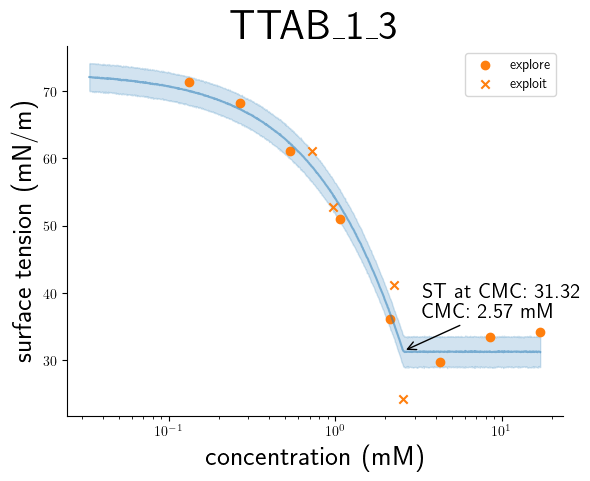

In [103]:
fig, ax1 = plt.subplots()

explore_mask = point_types == "explore"
exploit_mask = point_types == "exploit"

ax1.plot(x_new, st_fit_mean, c="C0", alpha=0.5, zorder=20)
ax1.fill_between(
    x_new,
    st_fit_mean - 2 * st_fit_std,
    st_fit_mean + 2 * st_fit_std,
    color="C0",
    alpha=0.2,
)

# Plot explore points with one marker
ax1.scatter(
    x_obs[explore_mask],
    y_obs[explore_mask],
    c="C1",
    label="explore",
    marker="o",
    zorder=15,
)

# Plot exploit points with another marker
ax1.scatter(
    x_obs[exploit_mask],
    y_obs[exploit_mask],
    c="C1",
    label="exploit",
    marker="x",
    zorder=15,
)

cmc_mean = post_pred["cmc"].mean(axis=0) * 1000
st_at_cmc, st_at_cmc_err, st_at_cmc_relative_err = calc_st_at_cmc(x_new, post_pred)
st_at_cmc = st_at_cmc * 1000
# Annotate properties
ax1.annotate(
    f"CMC: {cmc_mean:.2f} mM",
    xy=(cmc_mean, st_at_cmc),
    xytext=(cmc_mean * 1.3, st_at_cmc + 5),
    arrowprops=dict(facecolor="black", arrowstyle="->"),
    fontsize=15,
)
ax1.annotate(
    f"ST at CMC: {st_at_cmc:.2f}",
    xy=(cmc_mean, st_at_cmc),
    xytext=(cmc_mean * 1.3, st_at_cmc + 8),
    fontsize=15,
)

# ax1.set_xlim(0.01, 3)
ax1.set_xscale("log")
ax1.set_xlabel(r"concentration (mM)", fontsize=20)
ax1.set_ylabel("surface tension (mN/m)", fontsize=20)
ax1.set_title(f"{solution}", fontsize=30)
ax1.legend()
sns.despine()

plt.savefig(f"figures/isotherms/{solution}.svg", dpi=100, bbox_inches="tight")

Explore with errors bars

In [104]:
# experiment_tag = "AULAB_PSP0076"
# solution = "DTAB"
# results = pd.read_csv(f"experiments/{experiment_tag}/results.csv")
# results_solution = results[results["solution"].str.contains(solution)]
# results_explore = results_solution[results_solution["point type"] == "explore"]
# results_exploit = results_solution[results_solution["point type"] == "exploit"]

# grouped = (
#     results_explore.groupby("concentration")["surface tension eq. (mN/m)"]
#     .agg(["mean", "std"])
#     .reset_index()
# )

# c = grouped["concentration"]
# st_mean = grouped['mean']
# st_std = grouped['std']

# c_exploit = results_exploit["concentration"]
# st_exploit = results_exploit["surface tension eq. (mN/m)"]

In [105]:
# fig, ax = plt.subplots()

# # Scatter plot with error bars
# ax.errorbar(
#     x=c,
#     y=st_mean,
#     yerr=st_std,
#     fmt="o",  # Marker style for scatter points
#     ecolor="gray",  # Color of error bars
#     capsize=3,  # Length of error bar caps
#     label="Explore, n=3",
# )

# ax.scatter(
#     x=c_exploit,
#     y=st_exploit,
#     c="C1",
#     label="Exploit",
#     marker="x",
#     zorder=15,
# )

# # Add labels and title
# ax.set_xlabel("Concentration", fontsize=14)
# ax.set_ylabel("Surface Tension (mN/m)", fontsize=14)
# ax.set_title(f"{solution}", fontsize=16)

# ax.set_xscale('log')

# # Add legend
# ax.legend()

# # Show the plot
# # plt.show()
# plt.savefig(f"figures/{solution}_triplicate.svg", dpi=100, bbox_inches="tight")

In [106]:
df = pd.read_csv(f"experiments/{experiment_tag}/total_data.csv")
solution = "BDDAB"
df_solution = df[df["solution"].str.contains(solution)]
df_solution

,solution,CMC (mM),ST (mN/m)
0,BDDAB_1_1,32.54,4.33
1,BDDAB_1_2,32.91,3.38
2,BDDAB_1_3,32.59,3.86


### S3: image analysis pipeline

In [2]:
from analysis.image_analysis import PendantDropAnalysis

analyzer = PendantDropAnalysis()
file_path_figure = "figures/figure_S3_image_pipeline"
analyzer.load_raw_image(f"{file_path_figure}/example_droplet.png")
analyzer.process_image()
st = analyzer.analyse()
analyzer.save_analysis_image(file_path=f"{file_path_figure}/analysis.png")